In [96]:
# https://tutorials.pytorch.kr/intermediate/seq2seq_translation_tutorial.html

In [97]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
import numpy as np
from tqdm import tqdm
from torchvision import transforms, datasets
import torch.optim as optim
import torch.utils.data as data
import os
from PIL import Image
from __future__ import annotations

In [98]:
class EncoderRNN(nn.Module):
  def __init__(self, hidden_size: int = 256):
    super().__init__()
    self.hidden_size = hidden_size
    self.attan = nn.Linear(256, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)

  def forward(self, input, hidden):
    x = self.attan(input)
    return self.gru(x, hidden)

In [99]:
class CharRNNNetwork(nn.Module):
  def __init__(self, hidden_size: int = 256, max_length: int = 256, dropout: float = .2):
    super().__init__()
    self.attan = nn.Linear(256, hidden_size)
    self.dropout = nn.Dropout(dropout)
    self.attan2 = nn.Linear(hidden_size << 1, max_length)
    self.attan3 = nn.Linear(hidden_size << 1, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)
    self.out = nn.Linear(hidden_size, 256)
    self.hidden_size = hidden_size
    self.max_length = max_length

  def forward(self, input, hidden, encoder_outputs):
    """
    encoder_outputs = [size, max_length, hidden_size]
    """
    x = self.attan(input)
    x = self.dropout(x)
    weights = F.softmax(torch.cat((x[0], hidden[0]), dim = 1), dim = 1)
    weights = self.attan2(weights)
    applied = torch.bmm(weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
    x = torch.cat((x[0], applied[0]), dim = 1)
    x = self.attan3(x).unsqueeze(0)
    x = F.relu(x)
    x, hidden = self.gru(x, hidden)
    x = self.out(x[0])
    x = F.log_softmax(x, dim = 1)
    return x, hidden, weights

In [171]:
encoder = EncoderRNN()
decoder = CharRNNNetwork()

In [172]:
datasets = [
    ["Hello", "Hi"],
    ["I", "My"],
    ["I am", "I m"],
    ["Thankyou", "Thankyou!"],
    ["test code", "Test code"],
    ["It's work", "It is work"],
    ["He is", "He s"],
    ["he is", "he s"],
    ["He s", "He's"],
    ["he is", "he's"],
    ["you re", "you're"],
    ["She is", "She s"],
    ["she is", "she s"],
    ["She s", "She's"],
    ["she s", "she's"],
    ["You re", "You're"],
    ["I m", "I'm"],
    ["hello", "hi"],
    ["you are", "you re"],
    ["You are", "You re"],
    ["laugh of loud", "lol"],
    ["How are you", "H r u"],
    ["how are you", "h r u"],
    ["we are", "we re"],
    ["they are", "they re"],
    ["They are", "They re"],
    ["He's", "He is"],
    ["That is right", "That's right"],
    ["I am fine", "I m fine"],
    ["안녕하세요", "안녕"],
    ["반갑습니다", "반가워"],
    ["반가워요", "반가워"],
    ["안녕하십니까?", "안녕?"],
    ["안녕하세요?", "안녕?"],
    ["아버지가방에들어가신다", "아버지가 방에 들어가신다"],
    ["아기다리고기다리던여름방학", "아 기다리고 기다리던 여름방학"],
    ["인간", "사람"],
    ["ezreal", "is real"],
    ["lol", "laugh of loud"],
    ["hi", "hello"],
    ["h r u", "how are you"],
    ["H r u", "How are you"],
    ["LOL", "Laugh Of Loud"],
    ["What's your name?", "What is your name?"],
    ["what's your name?", "what is your name?"],
    ["What is your name?", "What's your name?"],
    ["what is your name?", "what's your name?"],
    ["How are you?", "H r u?"],
    ["Where is your cell phone?", "Where's your cell phone?"],
    ["where is your cell phone?", "where's your cell phone?"],
    ["That's right!", "That is right!"],
    ["that's right!", "that is right"],
    ["안녕하세요? 반갑습니다", "안녕? 반가워"],
]

In [173]:
def char2tensor(c):
  data = torch.zeros(1, 4, 256)
  if c.__len__() <= 0:
    return data
  c = ord(c)
  for i in range(4):
    data[0, i, c & 255] = 1.0
    c = c >> 8
  return data

In [174]:
def char2idx_tensor(c):
  data = torch.zeros(1, 4, dtype=torch.long)
  if c.__len__() <= 0:
    return data

  c = ord(c)
  for i in range(4):
    data[0, i] = c & 255
    c = c >> 8
  return data

In [175]:
def idx_tensor2number(arr: torch.Tensor):
  arr = arr.squeeze(0)
  c = 0
  for i in range(3, -1, -1):
    c = c << 8
    c = c | arr[i]

  return c.item()

In [176]:
chr(idx_tensor2number(char2idx_tensor('a')))

'a'

In [177]:
def show_plot(points):
  plt.figure()
  # fig, ax = plt.subplots()
  plt.plot(points)

In [178]:
def train(epochs: int = 100):
  encoder_optimizer = optim.SGD(encoder.parameters(), lr=.01)
  decoder_optimizer = optim.SGD(decoder.parameters(), lr=.01)
  criterion = nn.NLLLoss()

  losses = []

  for epoch in range(epochs):
    loss_avg = 0
    for i, (x, y) in enumerate(datasets):
      encoder_optimizer.zero_grad()
      decoder_optimizer.zero_grad()

      encoder_hidden = torch.zeros(1, 4, 256)
      encoder_outputs = torch.zeros(decoder.max_length, decoder.hidden_size)
      for i in range(x.__len__()):
        encoder_output, encoder_hidden = encoder(char2tensor(x[i]), encoder_hidden)
        encoder_outputs[i] = encoder_output[0, 0]

      decoder_input = torch.zeros(1, 4, 256)
      decoder_hidden = encoder_hidden

      loss = 0

      use_teacher_forcing = torch.rand(1)[0] < .5

      if use_teacher_forcing:
        for i in range(y.__len__()):
          decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
          loss += criterion(decoder_output, char2idx_tensor(y[i])[0])
          decoder_input = char2tensor(y[i])

      else:
        for i in range(y.__len__() + 1):
          decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
          loss += criterion(decoder_output, char2idx_tensor(y[i] if i < y.__len__() else '')[0])
          # decoded_number = idx_tensor2number(decoder_output.argmax(1))
          # if decoded_number <= 0 or decoded_number > 0x10FFFF:
          #   break

      loss.backward()

      encoder_optimizer.step()
      decoder_optimizer.step()

      loss_avg += (loss.item() - loss_avg) / (i + 1)

    losses.append(loss_avg)
    if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == epochs - 1:
      print("[{}/{}] Loss: {:.6F}".format(epoch + 1, epochs, loss_avg))

  show_plot(losses)


[1/700] Loss: 19.939134
[10/700] Loss: 11.215868
[20/700] Loss: 10.230900
[30/700] Loss: 9.633929
[40/700] Loss: 8.853672
[50/700] Loss: 8.169351
[60/700] Loss: 7.523326
[70/700] Loss: 6.523439
[80/700] Loss: 6.092049
[90/700] Loss: 5.415029
[100/700] Loss: 5.660186
[110/700] Loss: 4.647613
[120/700] Loss: 4.107303
[130/700] Loss: 4.719827
[140/700] Loss: 3.827069
[150/700] Loss: 4.358914
[160/700] Loss: 3.095305
[170/700] Loss: 2.918208
[180/700] Loss: 2.666474
[190/700] Loss: 2.282496
[200/700] Loss: 2.078222
[210/700] Loss: 1.754754
[220/700] Loss: 6.228471
[230/700] Loss: 1.765895
[240/700] Loss: 1.422950
[250/700] Loss: 3.605229
[260/700] Loss: 1.324232
[270/700] Loss: 1.152615
[280/700] Loss: 0.915059
[290/700] Loss: 2.861944
[300/700] Loss: 0.997237
[310/700] Loss: 0.750345
[320/700] Loss: 0.948995
[330/700] Loss: 0.752562
[340/700] Loss: 0.593201
[350/700] Loss: 0.397179
[360/700] Loss: 0.369187
[370/700] Loss: 8.159338
[380/700] Loss: 6.516795
[390/700] Loss: 4.595726
[400/700

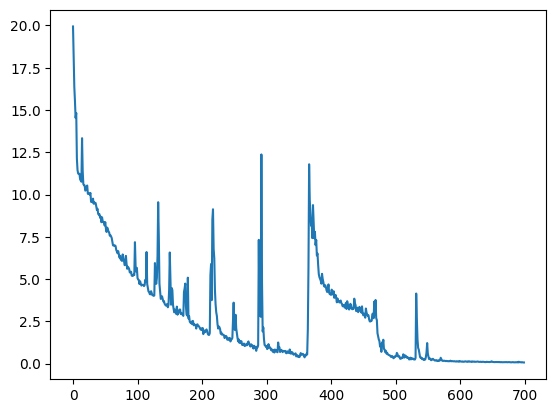

In [179]:
train(epochs = 700)

In [180]:
def evaluate(s):
  len = min(decoder.max_length, s.__len__())
  encoder_outputs = torch.zeros(decoder.max_length, decoder.hidden_size)
  encoder_hidden = torch.zeros(1, 4, 256)
  for i in range(len):
    encoder_output, encoder_hidden = encoder(char2tensor(s[i]), encoder_hidden)
    encoder_outputs[i] = encoder_output[0, 0]

  decoder_input = torch.zeros(1, 4, 256)
  decoder_hidden = encoder_hidden

  decoded_chars = []
  decoded_attensions = torch.zeros(decoder.max_length, decoder.max_length)

  for i in range(decoder.max_length):
    decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
    decoded_number = idx_tensor2number(decoder_output.argmax(1))
    decoded_attensions[i] = decoder_attention.max(0).values
    if decoded_number <= 0 or decoded_number > 0x10FFFF:
      decoded_chars.append('<EOS>')
      break

    decoded_chars.append(chr(decoded_number))

  return decoded_chars, decoded_attensions[:i + 1]

In [181]:
def show_attention(sentence, output_chars, attentions):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(attentions.detach().numpy(), cmap='bone')
  fig.colorbar(cax)

  ax.set_xticklabels([''] + list(sentence))
  ax.set_yticklabels([''] + output_chars)
  # ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()


def evalute_and_show(sentence: str):
  output_chars, attentions = evaluate(sentence)
  print(attentions.shape)
  print('input = ', sentence)
  print('output = ', ''.join(output_chars))
  show_attention(sentence, output_chars, attentions)

torch.Size([3, 256])
input =  안녕하세요
output =  안녕<EOS>


<ipython-input-181-a9a09b632efd>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(sentence))
<ipython-input-181-a9a09b632efd>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_chars)


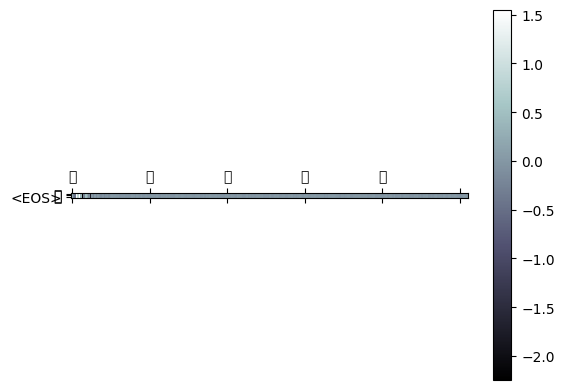

torch.Size([6, 256])
input =  hi
output =  hello<EOS>


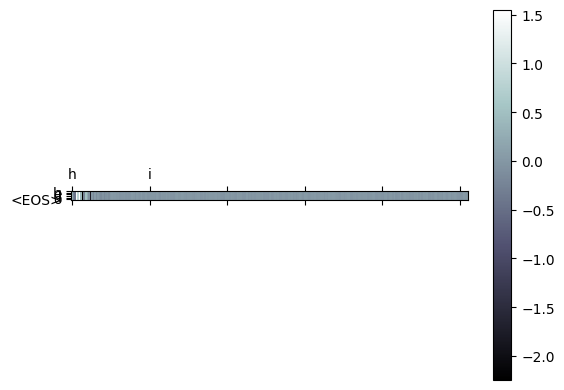

torch.Size([3, 256])
input =  반가워
output =  견貌<EOS>


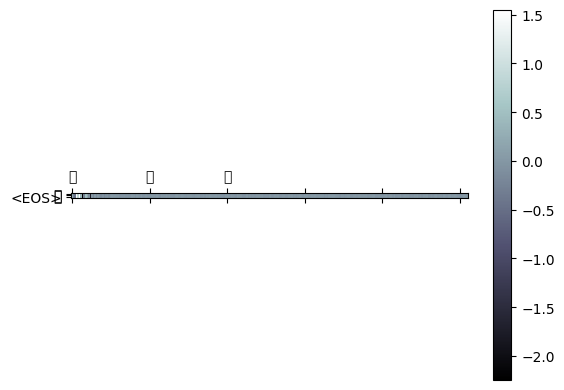

torch.Size([6, 256])
input =  She is
output =  She s<EOS>


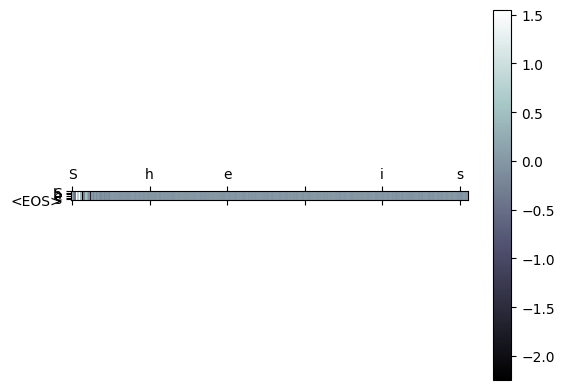

In [189]:
evalute_and_show("안녕하세요")
evalute_and_show("hi")
evalute_and_show("반가워")
evalute_and_show("She is")